#**Tratamiento de Señal EMG**

In [ ]:
#Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
#
#from scipy import signal
from tqdm import tqdm
from IPython.display import display
import csv
import sympy
from scipy.fft import fft
import scipy.signal as signal
from math import log10
#Cargar Datos desde archivo h5
from h5py import File
# biosignalsnotebooks python package
!pip install biosignalsnotebooks
import biosignalsnotebooks as bsnb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Cargar los datos del Cortex

In [ ]:
f = open("EEG vitalino.txt","r")
raw_data = f.readline()  # con f.read() leemos todo el contenido
f.close()

raw_data
# Expresion regular para buscar automaticamente el contenido de un numero dentro de un string
x = re.findall("[0-5][0-9]\d", raw_data)
Fs = 250
print(x)

[]


### Abrimos el archivo txt para ver  el contenido

In [ ]:
f = open("EEG_casco.txt","r")
raw_data = f.readline()  # con f.read() leemos todo el contenido
f.close()

raw_data

'%OpenBCI Raw EEG Data\n'

In [ ]:
## Expresion regular para buscar automaticamente el contenido de un numero dentro de un string
x = re.findall("[0-5][0-9]\d", raw_data)

print(x)

[]


In [ ]:
Fs = 250 #Frecuencia de Muestreo

In [ ]:
array = np.genfromtxt("./EEG_casco.txt", delimiter=", ",skip_header = 5)
#8 Canales del Cortex
d_sensor_8canales= array[:,1:9] #Para los 8 canales
Ts=1/Fs
n = np.arange(0,d_sensor_8canales.shape[0])
t = n*Ts #VECTOR TIEMPO 

###Graficando señal

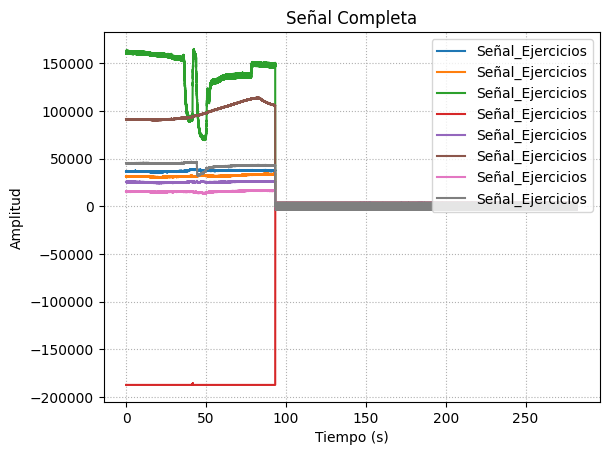

In [ ]:
plt.plot(t, d_sensor_8canales, label="Señal_Ejercicios")      # graficamos la señal
# plt.ylim(300,900)
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal Completa")
plt.legend(loc="upper right")
plt.show()
#graficar

####Cortando la *señal*

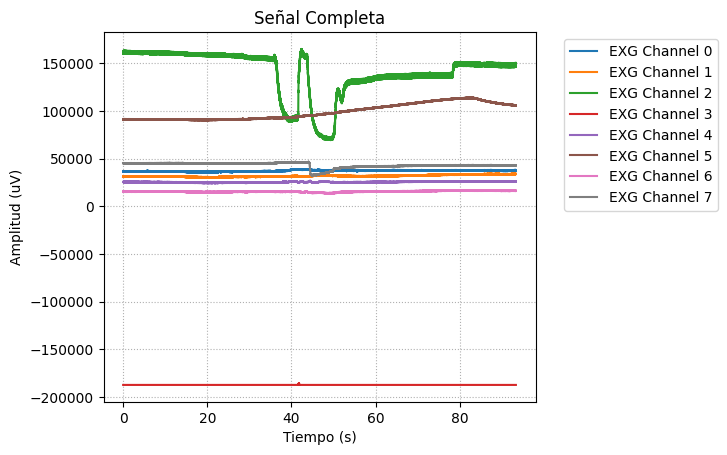

In [ ]:
#ACTUALIZAR EL CORTE DE LA SEÑAL
d_sensor_8canales= array[0:23335,1:9] #Para los 8 canales
#Actualizando la señal
n = np.arange(0,d_sensor_8canales.shape[0])
t = n*Ts #VECTOR TIEMPO 
plt.plot(t, d_sensor_8canales)        # 95 segundos
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (uV)")
plt.title("Señal Completa")
plt.legend(labels=["EXG Channel 0", "EXG Channel 1", "EXG Channel 2", "EXG Channel 3", "EXG Channel 4", "EXG Channel 5", "EXG Channel 6", "EXG Channel 7"], bbox_to_anchor=(1.05, 1))
plt.subplots_adjust(right=0.8)
plt.show()

Haciendo una ventana de la señal de 4667 datos y 5 frames

In [ ]:
def divide_array(arr, N):
    # Comprueba si el número de elementos en el array es múltiplo de N
    assert len(arr) % N == 0, "El número de elementos en el array debe ser un múltiplo de N"
    
    # Divide el array en subarrays de tamaño N
    subarrays = [arr[i:i+N] for i in range(0, len(arr), N)]
    
    return subarrays

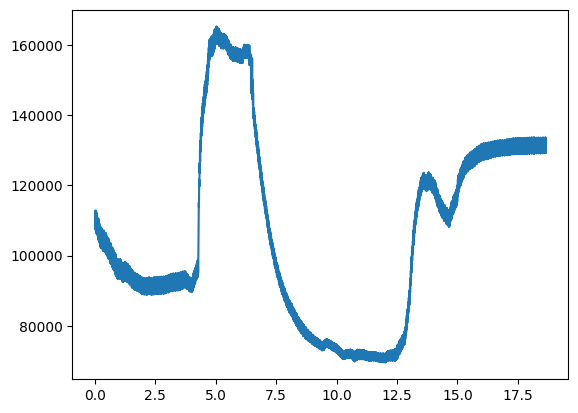

In [ ]:
d_sensor_8canales_divididos=divide_array(d_sensor_8canales, 4667)

#Escogiendo canal 3
d_sensor_divididos=divide_array(d_sensor_8canales[:,2], 4667)
n_window = np.arange(0,d_sensor_divididos[1].shape[0])
t_window = n_window*Ts #VECTOR TIEMPO 
#Escogiendo la ventana 3
signal_shift_window=d_sensor_divididos[2]
plt.plot(t_window,signal_shift_window)

####VIENDO EN EL ESPECTRO DE FRECUENCIAS

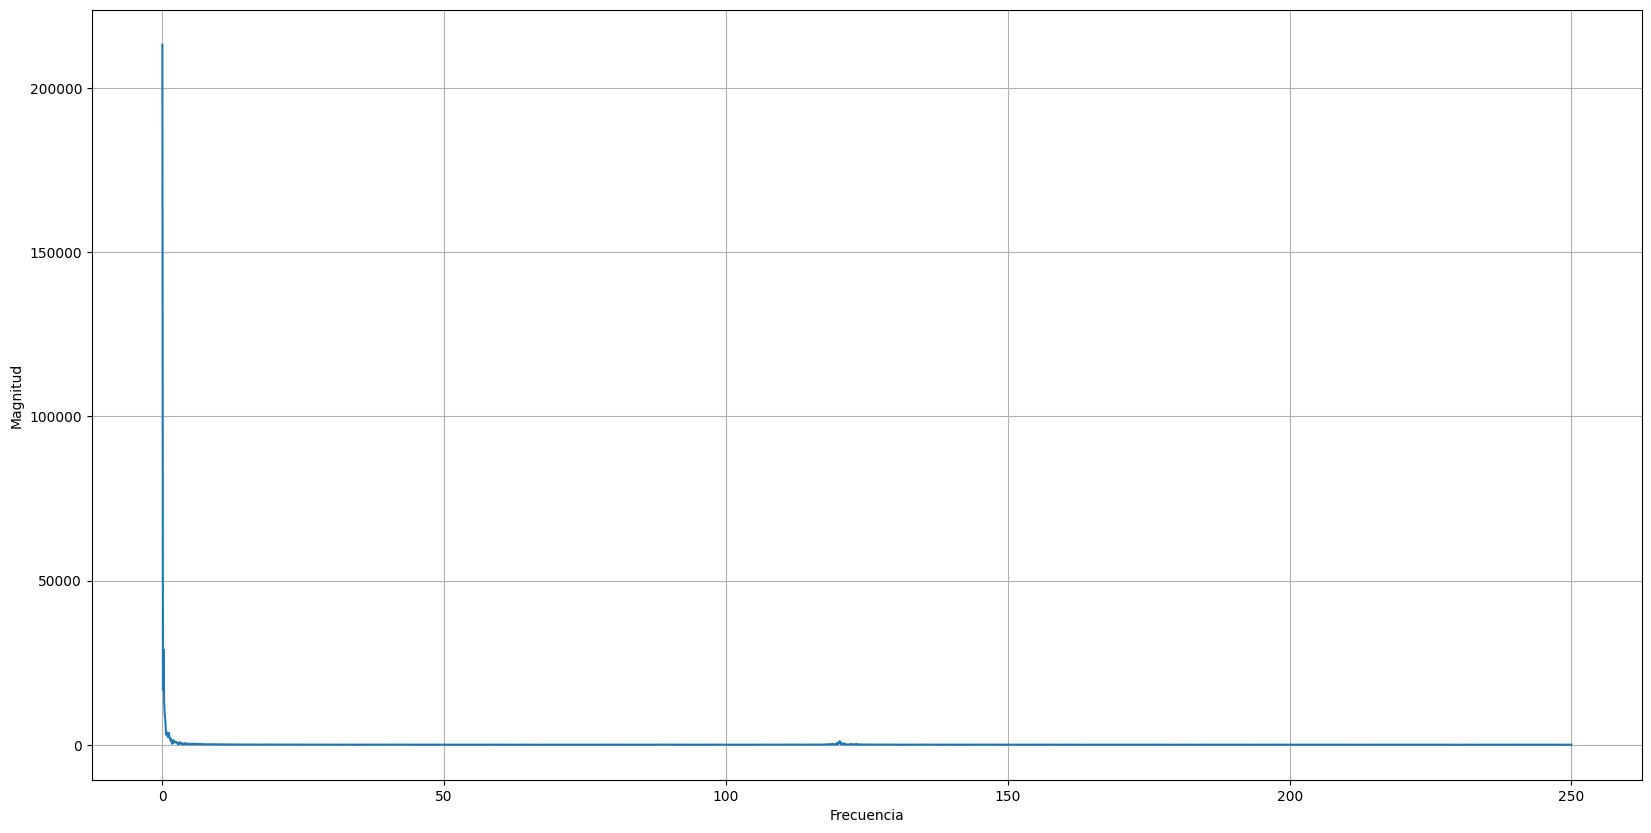

In [ ]:
T = 1/500 #Ver hasta 150 Hz
N = len(signal_shift_window)
yf = fft(signal_shift_window)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()

####Graficando los datos en un rango de Frecuencias de 0.5-100 Hz

Se observa un pico muy pronunciado en 0 Hz, Por ello se ubicará el grafico después de 1 Hz para analizar los picos de la gráfica restante.

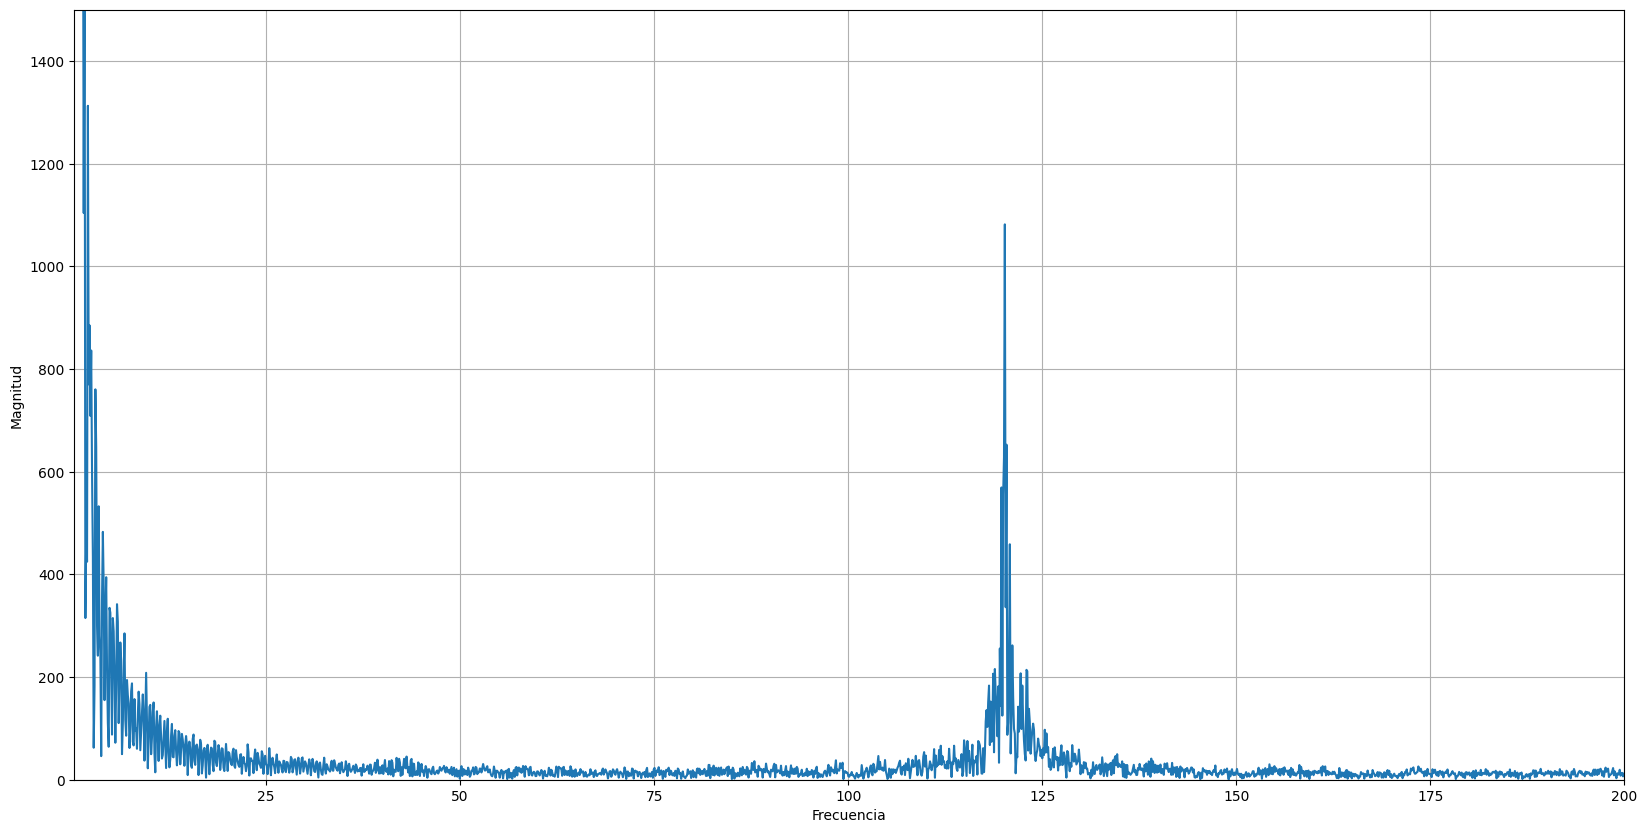

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.xlim(0.3,200)
plt.ylim(0,1500)
plt.ylabel("Magnitud")
plt.show()

##Filtrando de Señal

Se trabaja con una señal de 0-30 Hz

In [ ]:
#Ventana de tiempo
t_start=0
sample_start= t_start*Fs
t_end=30
sample_end=t_end*Fs


In [ ]:
#Frecuencia de Corte
#EEG trabaja en ese rango de frecuencias
low_cuttoff_wide=3 #Lower cutoff frequecy for bandpass filter (Hz)
high_cuttoff_wide=30 #Upper cutoff frequency for bandpass filter (Hz)

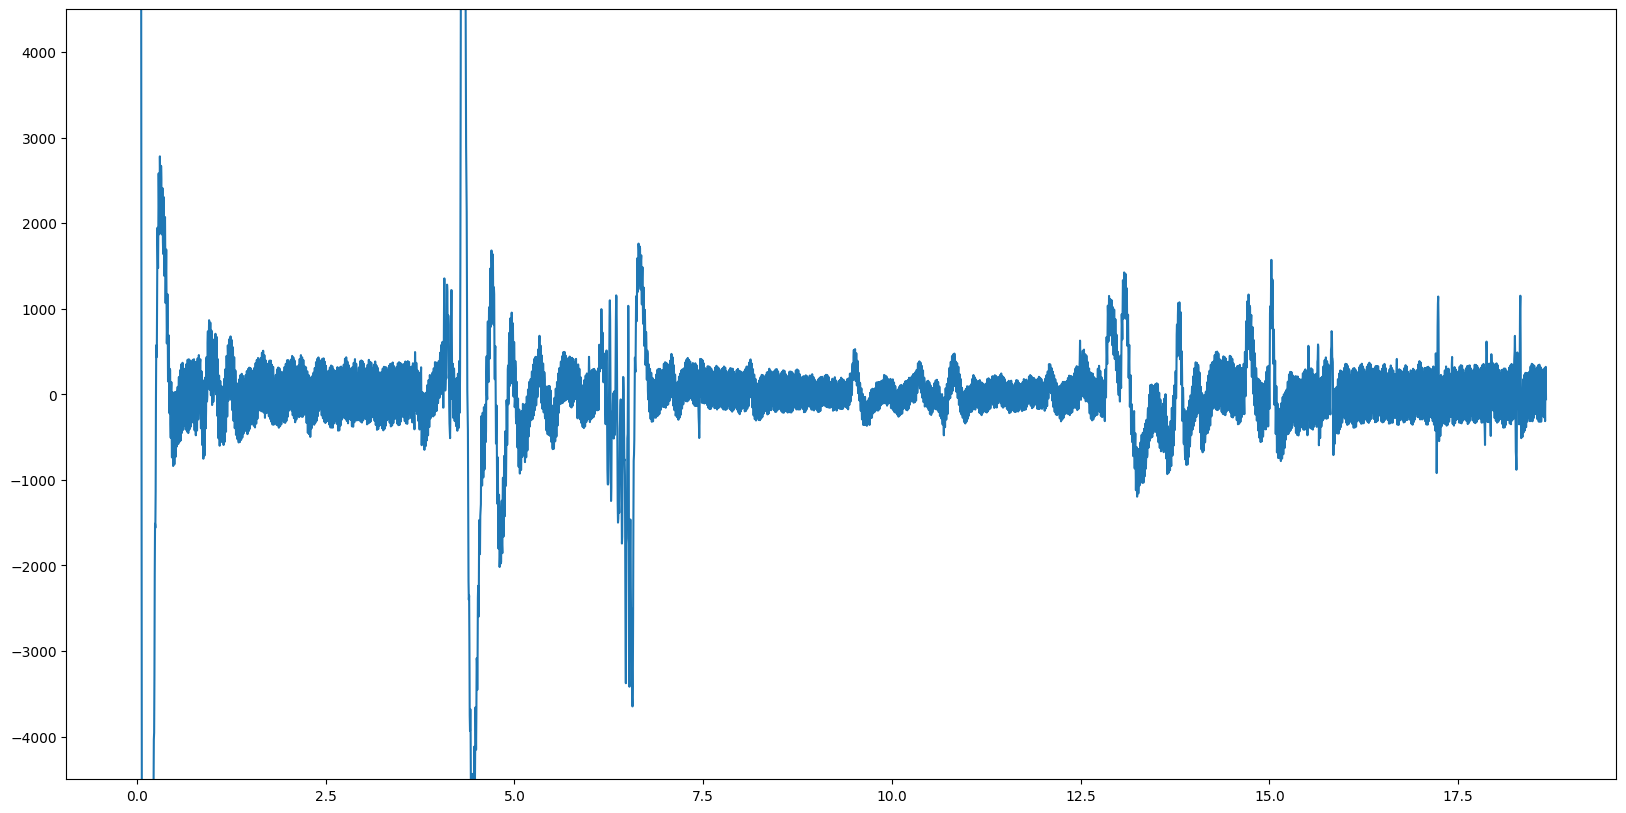

In [ ]:
#SOLO UNA VENTANA DE LA SEÑAL
filtered_signal_3_30= bsnb.bandpass(signal_shift_window,low_cuttoff_wide,high_cuttoff_wide,order=2,fs=Fs)
plt.figure(figsize=(20,10))
plt.ylim(-4500,4500)
plt.plot(t_window,filtered_signal_3_30)

####VIENDO EN EL ESPECTRO DE FRECUENCIAS

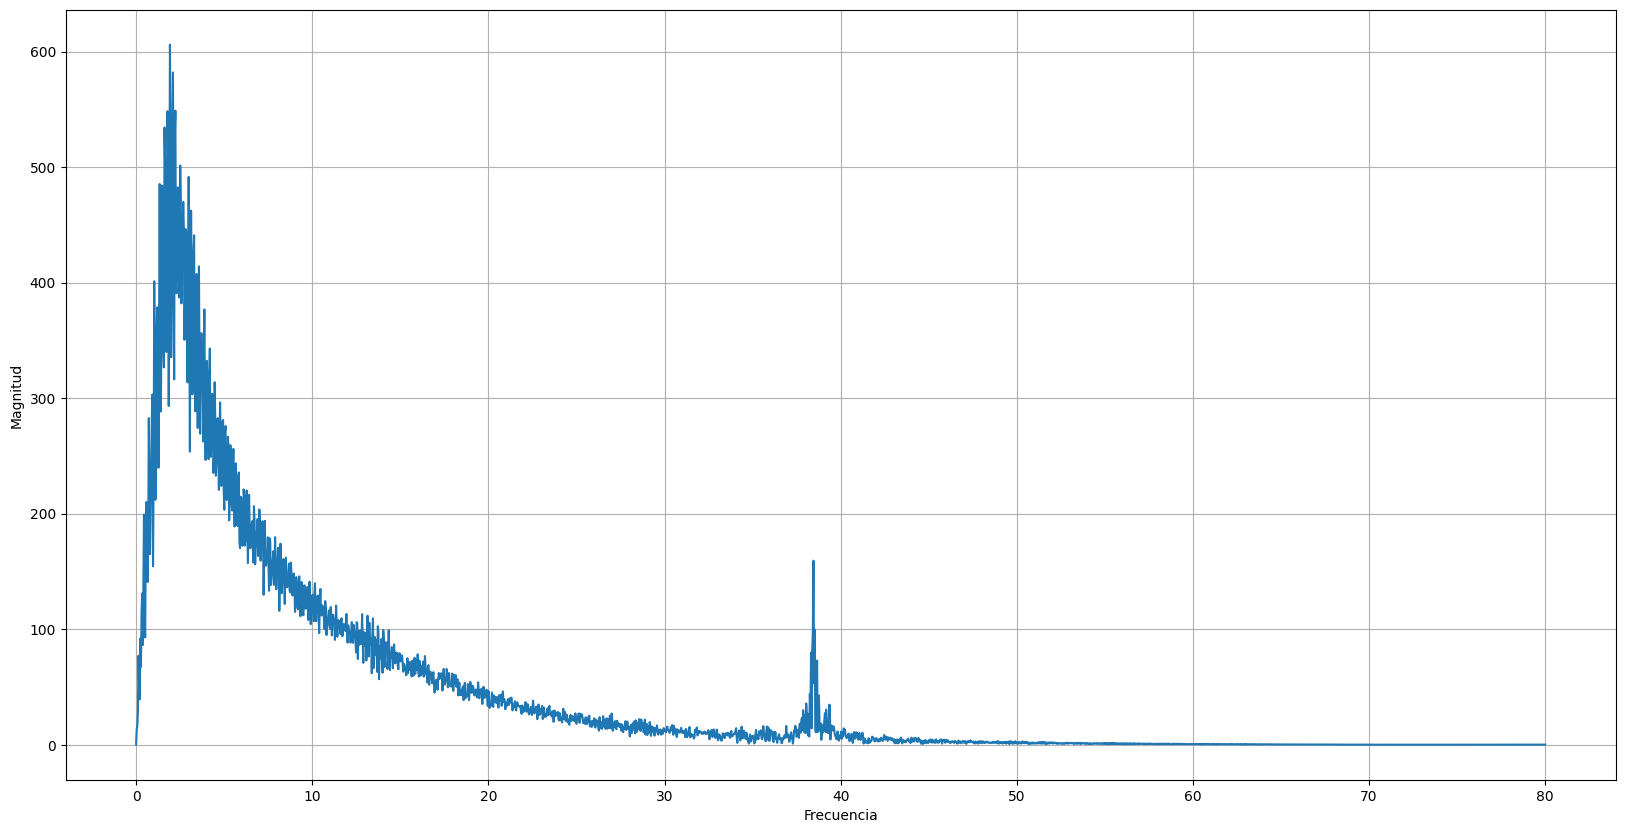

In [ ]:
T = 1/160 #Ver hasta 150 Hz
N = len(filtered_signal_3_30)
yf = fft(filtered_signal_3_30)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()

##Detección de ERP

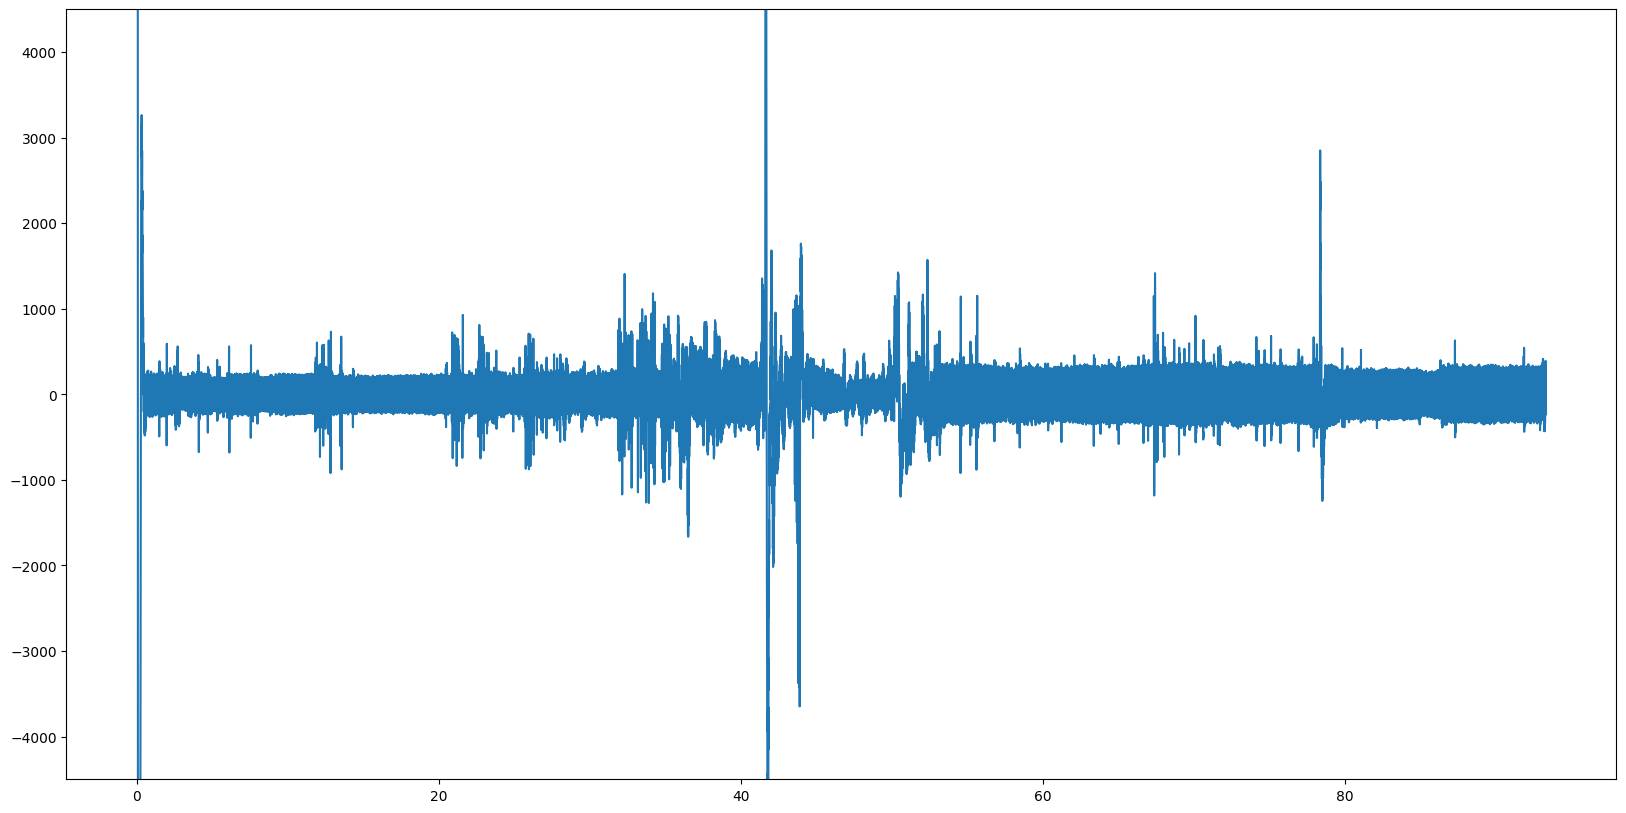

In [ ]:
#CONSIDERANDO LA SEÑAL DE CANAL 3
signal_acoustic=d_sensor_8canales[:,2]
#Filtrando la señal
signal_acoustic= bsnb.bandpass(signal_acoustic,low_cuttoff_wide,high_cuttoff_wide,order=2,fs=Fs)
plt.figure(figsize=(20,10))
plt.ylim(-4500,4500)
plt.plot(t,signal_acoustic)

###Viendo Espectro de frecuencias

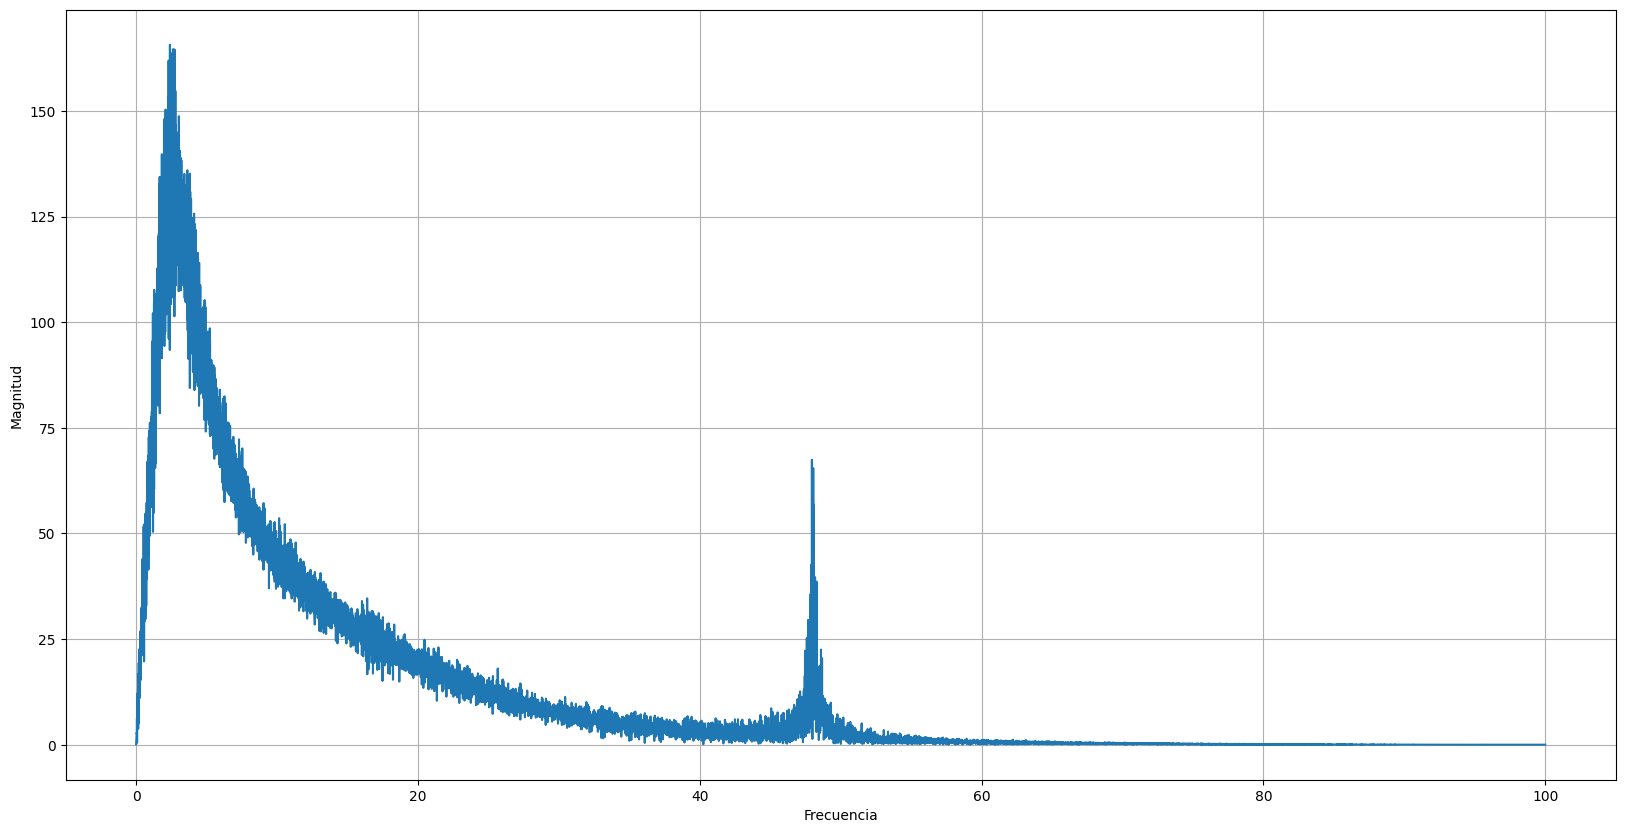

In [ ]:
T = 1/200 #Ver hasta 150 Hz
N = len(signal_acoustic)
yf = fft(signal_acoustic)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()

###ESTIMULO SONORO

In [ ]:
#Estímulo:
signal_ac = signal_acoustic - np.mean(signal_acoustic)
#Escogiendo de 10 en 10
time_a_down=t[::10]
signal_ac_down=signal_ac[::10]

####Graficando en Tiempo

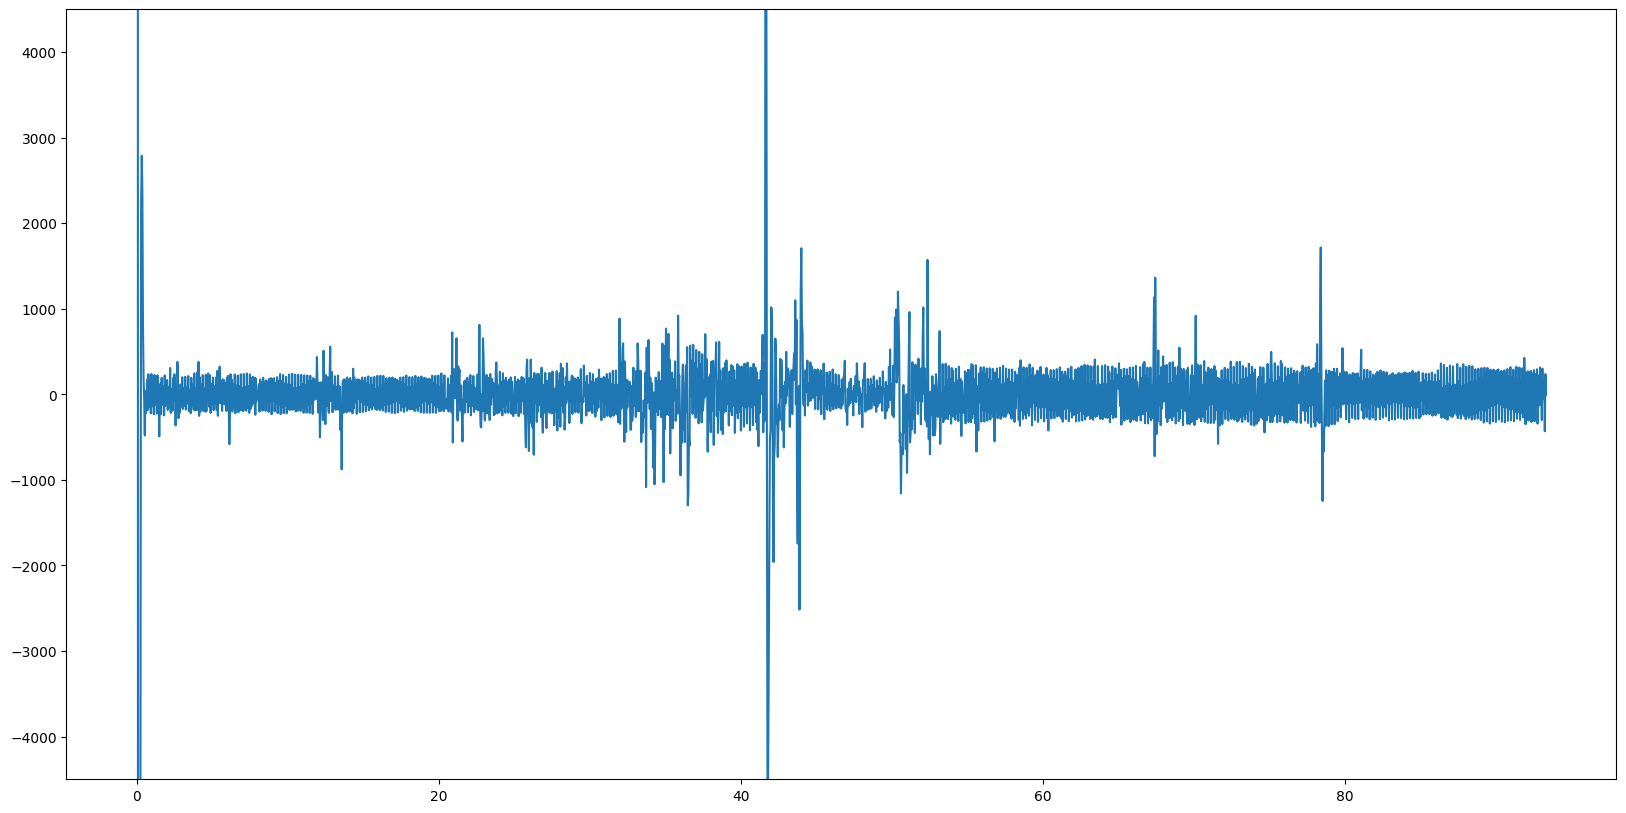

In [ ]:
plt.figure(figsize=(20,10))
plt.ylim(-4500,4500)
plt.plot(time_a_down,signal_ac_down)

####Graficando en Frecuencias

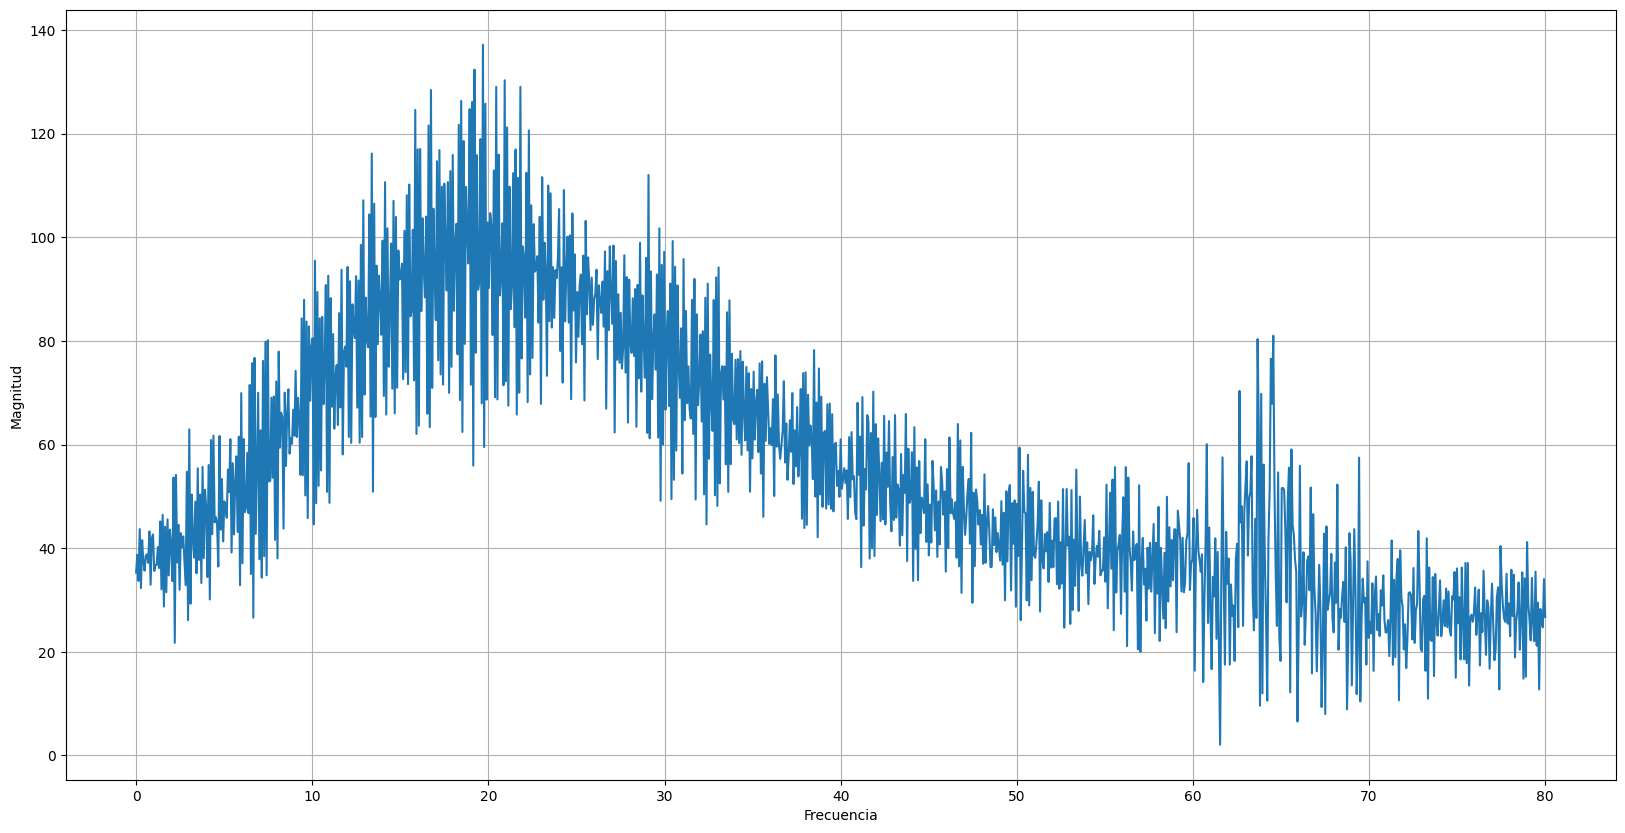

In [ ]:
T = 1/160 #Ver hasta 150 Hz
N = len(signal_ac_down)
yf = fft(signal_ac_down)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()

##Extracción de la banda Alfa

In [ ]:
#Definición de Los Límites de La banda de frecuencia:
freq_low = 8 #lower Limit for aLpha band
freq_high = 12 #Upper I imit for alpha band
freq_axis_eyes_opened=[0,10,20,30,40,50,60]

#FFT
T = 1/160 #Ver hasta 150 Hz
N = len(signal_ac_down)
yf = fft(signal_ac_down)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
power_spect_eyes_opened=2.0/N * np.abs(yf[0:N//2])

valor_buscado = np.max(power_spect_eyes_opened )
idx_alpha_eyes_opened = np.where(power_spect_eyes_opened == valor_buscado)[0]
freq_res_opened_eyes=freq_axis_eyes_opened[1]-freq_axis_eyes_opened[0]
print(indices)
#Compute the Absolute Powe with numpy.trapz
alpha_power_opened_eyes=np.trapz(power_spect_eyes_opened[idx_alpha_eyes_opened],dx=freq_res_opened_eyes)

[287]
